>>	Avg scipy error:          17.06%	max 61.91%	min 00.80%	var 00.37
>>	Avg prediction error:     18.31%	max 60.00%	min 00.37%	var 00.00
>>	Avg MLP prediction error: 30.62%	max 85.00%	min 00.00%	var 00.03



/home/david/.virtualenvs/sonarapp-utils/lib/python3.7/site-packages/ipykernel_launcher.py:179: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/david/.virtualenvs/sonarapp-utils/lib/python3.7/site-packages/ipykernel_launcher.py:152: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/david/.virtualenvs/sonarapp-utils/lib/python3.7/site-packages/ipykernel_launcher.py:168: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


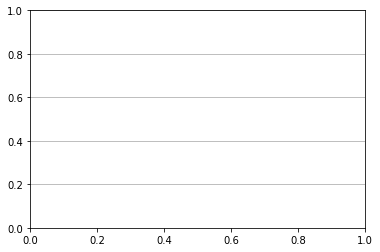

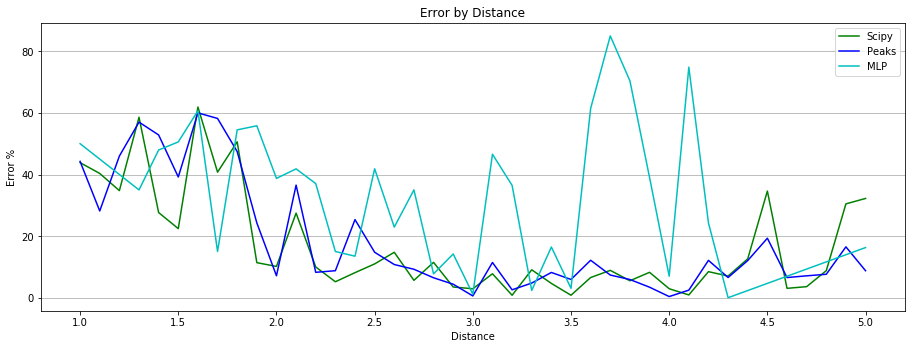

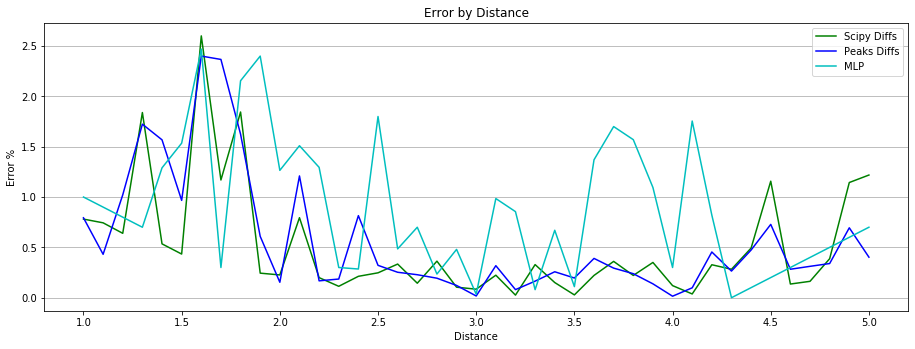

In [14]:
%matplotlib inline

import pickle
import numpy as np
import matplotlib.pyplot as plt

import analysis as an
import cross_correlation_analyzer as cca


def main():
    temp = 19
    sound_of_speed = an.get_speed_of_sound(temp)
    threshold = 10.0 ** 0.85
    holder_distance = 0.35
    frames_to_reach_phone_holder = np.ceil(
        an.SAMPLE_RATE * (holder_distance * 2 / sound_of_speed))
    distance = int(an.CHIRP_DURATION * an.SAMPLE_RATE * 0.5
                   + frames_to_reach_phone_holder)
    locations = [
        'david_alley',
        # 'david_tv_wall',
#         'david_hospital',
    ]

    with open(an.LONGEST_CC_FILE, "r") as f:
        longest_cc = int(f.readline())

    with open(an.MLP_INSTANCE_FILE, "rb") as f:
        mlp_instance = pickle.load(f)

    start_distance = 1.0
    # vvv Exclusive vvv
    stop_distance = 5.09
    step = 0.1

    def get_avg(dst, _prefix):
        an.PREFIX = "{0}.{1:.1f}m.".format(_prefix, dst)
        mlp_distances = []
        scipy_distances = []
        prediction_distances = []
        for sample_number in range(1, 21):
            try:
                sample = an.load_sample(sample_number)
            except FileNotFoundError:
                continue

            prediction = sample['peaks_prediction']
            if prediction > 0:
                prediction_distances.append(prediction)

            cc = cca.get_cc(sample_number)

            padded_cc = cc[:longest_cc] + [0] * (
                    longest_cc - len(cc[:longest_cc])
            )
            mlp_prediction = mlp_instance.predict([padded_cc])[0]
            mlp_distances.append(mlp_prediction)

            time_delta, speed_of_sound, half_distance, peaks = \
                cca.get_distances(cc, threshold, distance, temp)
            if half_distance:
                scipy_distances.append(half_distance)
        if not (scipy_distances and prediction_distances and mlp_distances):
            return [None] * 3
        return (np.mean(scipy_distances),
                np.mean(prediction_distances),
                np.mean(mlp_distances))

    scipy_errors = []
    prediction_errors = []
    mlp_prediction_errors = []
    scipy_diffs = []
    prediction_diffs = []
    mlp_prediction_diffs = []

    distances = np.arange(start_distance, stop_distance, step)
    for location in locations:
        for dst in distances:
            scipy_avg, prediction_avg, mlp_avg = get_avg(dst, location)
            if not (scipy_avg and prediction_avg and mlp_avg):
                continue
            
            scipy_diffs.append(np.abs(dst - scipy_avg))
            scipy_error = np.abs(1 - dst / scipy_avg)
            scipy_errors.append(scipy_error)
            
            prediction_diffs.append(np.abs(dst - prediction_avg))
            prediction_error = np.abs(1 - dst / prediction_avg)
            prediction_errors.append(prediction_error)
            
            mlp_prediction_diffs.append(np.abs(dst - mlp_avg / 10.0))
            mlp_prediction_error = np.abs(1 - 10.0 * dst / mlp_avg)
            mlp_prediction_errors.append(mlp_prediction_error)

            if not PRINT_INTERMEDIATE_RESULTS:
                continue
            print(
                "Avg distance calc for distance {0:.1f}m location {7}:\n"
                "Scipy      - {1:.2f}m\t(error) {2:05.2f}%\n"
                "Prediction - {3:.2f}m\t(error) {4:05.2f}%\n"
                "MLP        - {5:.2f}m\t(error) {6:05.2f}%\n"
                "------------------------------------"
                "".format(dst,
                          scipy_avg,
                          scipy_error * 100,
                          prediction_avg,
                          prediction_error * 100,
                          mlp_avg / 10.0,
                          mlp_prediction_error * 100,
                          location)
            )

    print(
        ">>\tAvg scipy error:          {0:05.2f}%"
        "\tmax {3:05.2f}%\tmin {6:05.2f}%\tvar {7:05.2f}\n"

        ">>\tAvg prediction error:     {1:05.2f}%"
        "\tmax {4:05.2f}%\tmin {7:05.2f}%\tvar {8:05.2f}\n"

        ">>\tAvg MLP prediction error: {2:05.2f}%"
        "\tmax {5:05.2f}%\tmin {8:05.2f}%\tvar {9:05.2f}\n"
        "".format(np.mean(scipy_errors) * 100,
                  np.mean(prediction_errors) * 100,
                  np.mean(mlp_prediction_errors) * 100,
                  np.max(scipy_errors) * 100,
                  np.max(prediction_errors) * 100,
                  np.max(mlp_prediction_errors) * 100,
                  np.min(scipy_errors) * 100,
                  np.min(prediction_errors) * 100,
                  np.min(mlp_prediction_errors) * 100,
                  np.var(scipy_errors),
                  np.var(prediction_errors),
                  np.var(mlp_prediction_errors))
    )
    # Doesn't work on multiple locations
    x = distances.tolist()
    fig = graph_errors(x, 
                       percentage(scipy_errors), 
                       "Scipy", 
                       color='g')
    fig = graph_errors(x,
                       percentage(prediction_errors),
                       "Peaks",
                       fig,
                       color='b')
    fig = graph_errors(x,
                       percentage(mlp_prediction_errors),
                       "MLP",
                       fig,
                       color='c')
    fig.show()
    
    fig = graph_errors(x, 
                       scipy_diffs, 
                       "Scipy Diffs", 
                       color='g')
    fig = graph_errors(x,
                       prediction_diffs,
                       "Peaks Diffs",
                       fig,
                       color='b')
    fig = graph_errors(x,
                       mlp_prediction_diffs,
                       "MLP",
                       fig,
                       color='c')
    fig.show()


def percentage(a):
    return [i * 100 for i in a]


def graph_errors(x, y, label, fig=None, color='green', title="Error by Distance"):
    plt.grid(True, axis='y')
    if not fig:
        fig = plt.figure()
    ax = fig.add_axes([0, 0, 2, 1])
    ax.set_xlabel('Distance')
    ax.set_ylabel('Error %')
    ax.set_title(title)
    ax.plot(x, y, label=label, color=color)
    ax.legend()
    return fig


PRINT_INTERMEDIATE_RESULTS = False
main()
